<a href="https://colab.research.google.com/github/safeai-snu/TimeSeriesAI/blob/main/ch3/ch3_Transformer_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neuralforecast datasetsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 373.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast.losses.numpy import mae
from neuralforecast.core import NeuralForecast
from neuralforecast.models import Informer, Autoformer, PatchTST
from datasetsforecast.long_horizon import LongHorizon

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Data 전처리

In [3]:
data_gold = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/TimeSeriesAI/refs/heads/main/ch3/dataset/gold.csv')
data_silver = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/TimeSeriesAI/refs/heads/main/ch3/dataset/silver.csv')

In [4]:
def standard_scaler(data):
    mean = data['y'].mean()
    std = data['y'].std()
    data['y'] = (data['y']-mean)/std
    return mean, std, data

In [5]:
mean_gold, std_gold, data_gold = standard_scaler(data_gold)
mean_silver, std_silver, data_silver = standard_scaler(data_silver)

In [6]:
data = pd.concat([data_gold,data_silver])
data

,ds,y,unique_id
0,0,-1.336501,gold
1,1,-1.323519,gold
2,2,-1.260577,gold
3,3,-1.291655,gold
4,4,-1.246415,gold
...,...,...,...
1285,1285,0.951773,silver
1286,1286,0.983087,silver
1287,1287,0.920697,silver
1288,1288,0.968616,silver


### **학습**

In [7]:
horizon = 1

In [8]:
%%capture
models_tf = [Informer(h=horizon,                    # Forecasting horizon
                      input_size=10,                # Input size
                      max_steps=2000,               # Number of training iterations
                      val_check_steps=100,          # Compute validation loss every 100 steps
                      early_stop_patience_steps=3), # Stop training if validation loss does not improve
             Autoformer(h=horizon,
                        input_size=30,
                        max_steps=1000,
                        val_check_steps=100,
                        early_stop_patience_steps=3),
             PatchTST(h=horizon,
                        input_size=30,
                        max_steps=1000,
                        val_check_steps=100,
                        early_stop_patience_steps=3),
             ]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [15]:
tf = NeuralForecast(models=models_tf, freq=1)

data_tf = tf.cross_validation(df=data,
                               val_size=int(.1*len(data.ds.unique())),
                               test_size=int(.1*len(data.ds.unique())),
                               n_windows=None)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 384    | train
4 | dec_embedding | DataEmbedding | 384    | train
5 | encoder       | TransEncoder  | 199 K  | train
6 | decoder       | TransDecoder  | 141 K  | train
--------------------------------------------------------
341 K     Trainable params
0         Non-trainable params
341 K     Total params
1.368     Total estim

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 148 K  | train
7 | decoder       | Decoder       | 141 K  | train
--------------------------------------------------------
290 K     Trainable params
0         Non-trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 400 K  | train
-----------------------------------------------------------
400 K     Trainable params
3         Non-trainable params
400 K     Total params
1.602     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [16]:
data_tf = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/TimeSeriesAI/refs/heads/main/ch3/dataset/gold_silver_pretrained.csv')

In [17]:
tf_predict = data_tf[data_tf['ds']-data_tf['cutoff']==horizon]
tf_predict

,Unnamed: 0,unique_id,ds,cutoff,Informer,Autoformer,PatchTST,y
0,0,gold,1161,1160,1.086148,1.072559,1.116271,1.150495
1,1,gold,1162,1161,1.131429,1.105817,1.175186,1.153642
2,2,gold,1163,1162,1.133152,1.170764,1.169328,1.181573
3,3,gold,1164,1163,1.158979,1.144914,1.184329,1.174098
4,4,gold,1165,1164,1.145016,1.174784,1.190378,1.215010
...,...,...,...,...,...,...,...,...
253,253,silver,1285,1284,0.910531,0.980750,0.923755,0.951773
254,254,silver,1286,1285,0.915956,0.985441,0.948709,0.983087
255,255,silver,1287,1286,0.972305,1.009074,0.983380,0.920697
256,256,silver,1288,1287,0.924850,0.944526,0.931675,0.968616


In [18]:
tf_gold = tf_predict[tf_predict['unique_id']=='gold']
tf_silver = tf_predict[tf_predict['unique_id']=='silver']

In [19]:
tf_gold

,Unnamed: 0,unique_id,ds,cutoff,Informer,Autoformer,PatchTST,y
0,0,gold,1161,1160,1.086148,1.072559,1.116271,1.150495
1,1,gold,1162,1161,1.131429,1.105817,1.175186,1.153642
2,2,gold,1163,1162,1.133152,1.170764,1.169328,1.181573
3,3,gold,1164,1163,1.158979,1.144914,1.184329,1.174098
4,4,gold,1165,1164,1.145016,1.174784,1.190378,1.215010
...,...,...,...,...,...,...,...,...
124,124,gold,1285,1284,1.190178,1.217738,1.199172,1.207929
125,125,gold,1286,1285,1.186163,1.179539,1.200946,1.216191
126,126,gold,1287,1286,1.207499,1.189658,1.208708,1.196128
127,127,gold,1288,1287,1.190244,1.166427,1.199881,1.228779


### **결과 분석**

In [20]:
tf_gold[['Informer','Autoformer','PatchTST','y']] = tf_gold[['Informer','Autoformer','PatchTST','y']]*std_gold + mean_gold
tf_silver[['Informer','Autoformer','PatchTST','y']] = tf_silver[['Informer','Autoformer','PatchTST','y']]*std_silver + mean_silver

<ipython-input-20-546c5f3abecf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_gold[['Informer','Autoformer','PatchTST','y']] = tf_gold[['Informer','Autoformer','PatchTST','y']]*std_gold + mean_gold
<ipython-input-20-546c5f3abecf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_silver[['Informer','Autoformer','PatchTST','y']] = tf_silver[['Informer','Autoformer','PatchTST','y']]*std_silver + mean_silver


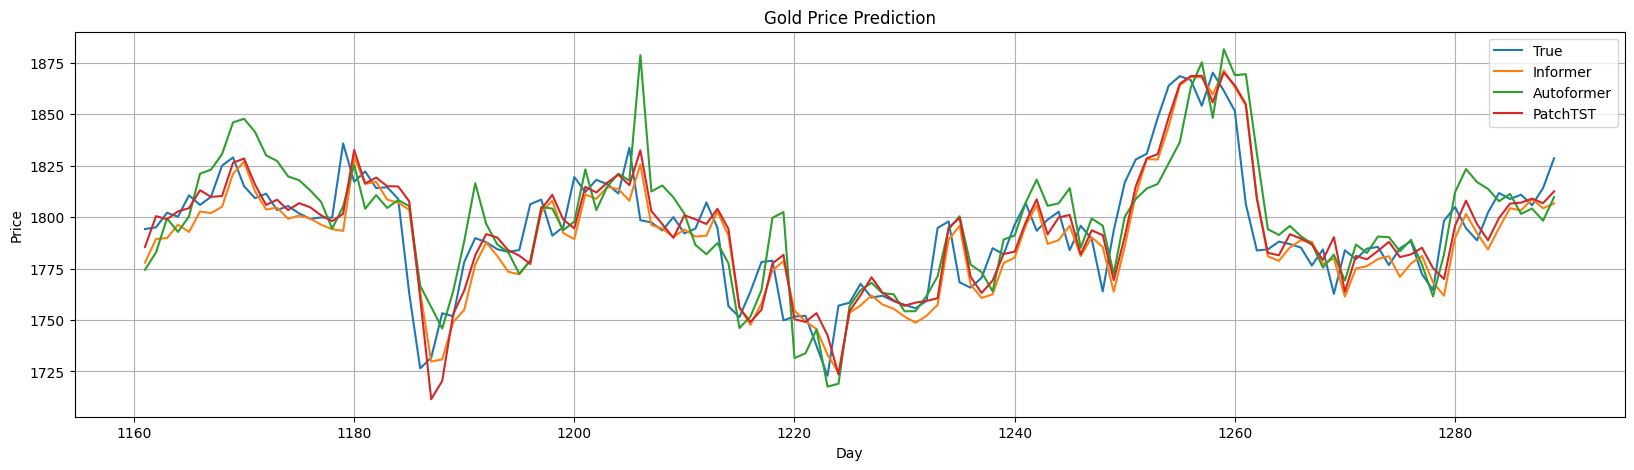

In [21]:
plt.figure(figsize=(20,5))
plt.plot(tf_gold['ds'], tf_gold['y'], label='True')
plt.plot(tf_gold['ds'], tf_gold['Informer'], label='Informer')
plt.plot(tf_gold['ds'], tf_gold['Autoformer'], label='Autoformer')
plt.plot(tf_gold['ds'], tf_gold['PatchTST'], label='PatchTST')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Gold Price Prediction')
plt.grid()
plt.legend()
plt.savefig('gold_tf_5step.png')
plt.show()

In [22]:
mae_informer = mae(tf_gold['y'], tf_gold['Informer'])
mae_autoformer = mae(tf_gold['y'], tf_gold['Autoformer'])
mae_patchtst = mae(tf_gold['y'], tf_gold['PatchTST'])

print(f'Informer: {mae_informer:.3f}')
print(f'Autoformer: {mae_autoformer:.3f}')
print(f'PatchTST: {mae_patchtst:.3f}')

Informer: 11.837
Autoformer: 14.875
PatchTST: 11.125


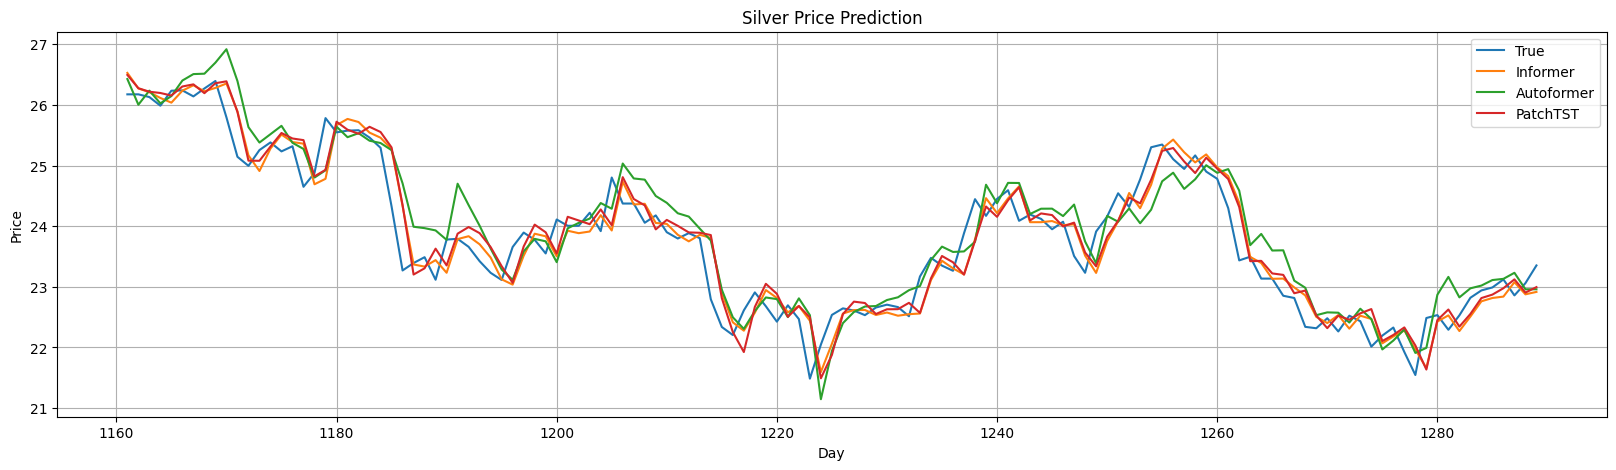

In [23]:
plt.figure(figsize=(20,5))
plt.plot(tf_silver['ds'], tf_silver['y'], label='True')
plt.plot(tf_silver['ds'], tf_silver['Informer'], label='Informer')
plt.plot(tf_silver['ds'], tf_silver['Autoformer'], label='Autoformer')
plt.plot(tf_silver['ds'], tf_silver['PatchTST'], label='PatchTST')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Silver Price Prediction')
plt.grid()
plt.legend()
plt.savefig('silver_tf_5step.png')
plt.show()

In [24]:
mae_informer = mae(tf_silver['y'], tf_silver['Informer'])
mae_autoformer = mae(tf_silver['y'], tf_silver['Autoformer'])
mae_patchtst = mae(tf_silver['y'], tf_silver['PatchTST'])

print(f'Informer: {mae_informer:.3f}')
print(f'Autoformer: {mae_autoformer:.3f}')
print(f'PatchTST: {mae_patchtst:.3f}')

Informer: 0.294
Autoformer: 0.375
PatchTST: 0.306


### **AirPassengers Data**
Reference: https://github.com/Nixtla/neuralforecast/blob/main/nbs/examples/Getting_Started.ipynb

In [25]:
from neuralforecast.utils import AirPassengersDF

Y_df = AirPassengersDF
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


<Axes: >

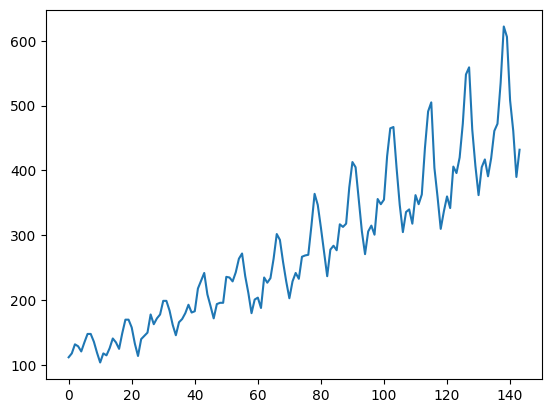

In [26]:
Y_df['y'].plot()

In [27]:
%%capture
horizon = 12
models = [Informer(h=horizon,                 # Forecasting horizon
                input_size=2*horizon,           # Input size
                max_steps=500), # Stop training if validation loss does not improve
          Autoformer(h=horizon,
                input_size=2*horizon,
                max_steps=100),
          PatchTST(h=horizon,
                input_size=2*horizon,
                max_steps=100),
         ]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [28]:
nf = NeuralForecast(models=models, freq='M')

data_nf = nf.cross_validation(df=Y_df,
                               val_size=int(.1*len(Y_df.ds.unique())),
                               test_size=int(.1*len(Y_df.ds.unique())),
                               n_windows=None)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 384    | train
4 | dec_embedding | DataEmbedding | 384    | train
5 | encoder       | TransEncoder  | 199 K  | train
6 | decoder       | TransDecoder  | 141 K  | train
--------------------------------------------------------
341 K     Trainable params
0         Non-trainable params
341 K     Total params
1.368     Total estim

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 148 K  | train
7 | decoder       | Decoder       | 141 K  | train
--------------------------------------------------------
290 K     Trainable params
0         Non-trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 404 K  | train
-----------------------------------------------------------
404 K     Trainable params
3         Non-trainable params
404 K     Total params
1.618     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [35]:
nf_predict = data_nf[data_nf['cutoff']=='1959-12-31']

In [36]:
nf_predict

,ds,cutoff,Informer,Autoformer,PatchTST,y
unique_id,,,,,,
1.0,1960-01-31,1959-12-31,13.991575,465.177002,418.907867,417.0
1.0,1960-02-29,1959-12-31,14.034287,464.829926,409.195251,391.0
1.0,1960-03-31,1959-12-31,13.999046,479.976135,462.608887,419.0
1.0,1960-04-30,1959-12-31,14.042659,494.966675,466.371338,461.0
1.0,1960-05-31,1959-12-31,14.042113,516.403015,485.472473,472.0
1.0,1960-06-30,1959-12-31,14.031226,555.471008,569.334839,535.0
1.0,1960-07-31,1959-12-31,14.038815,600.389648,648.508850,622.0
1.0,1960-08-31,1959-12-31,14.041873,604.504639,629.712769,606.0
1.0,1960-09-30,1959-12-31,14.025721,552.592163,556.182129,508.0


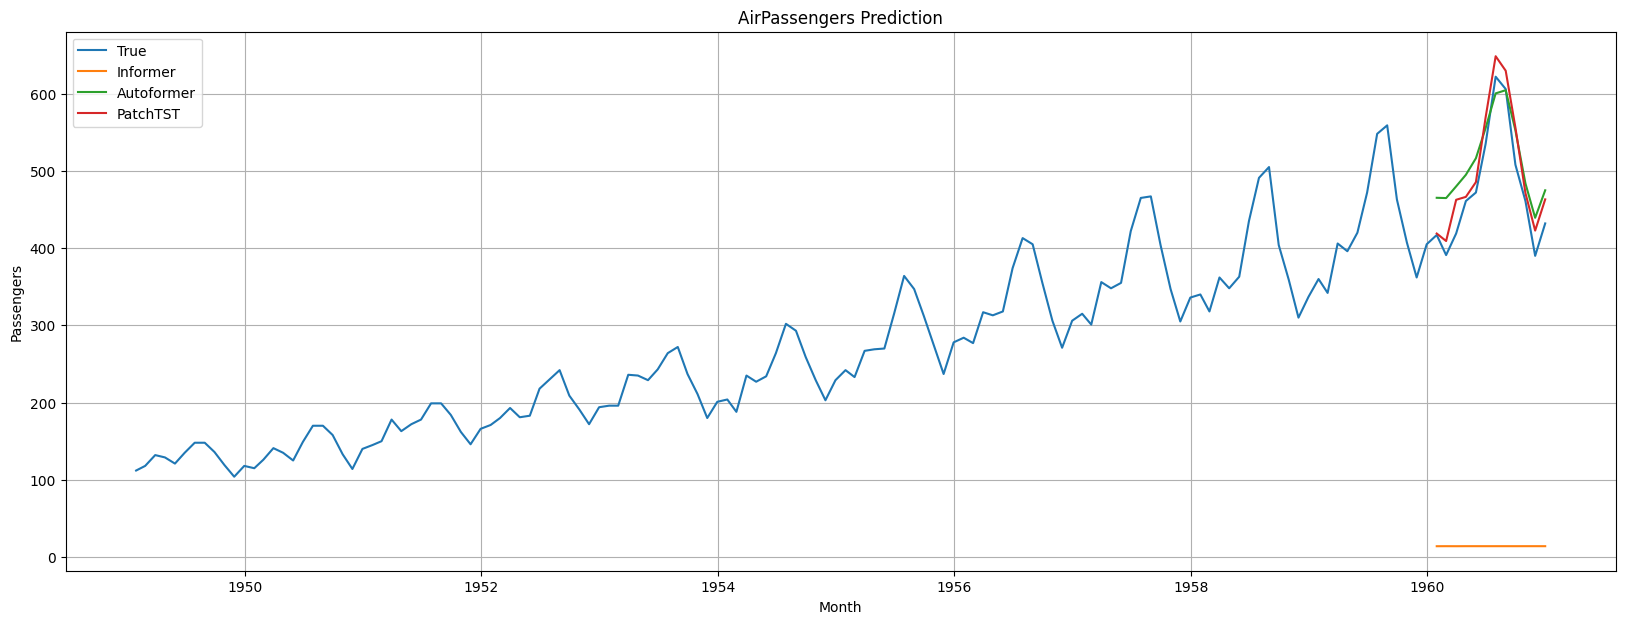

In [37]:
plt.figure(figsize=(20,7))
plt.plot(Y_df['ds'], Y_df['y'], label='True')

for models in ['Informer','Autoformer','PatchTST']:
    plt.plot(nf_predict['ds'], nf_predict[models], label=models)
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.title('AirPassengers Prediction')
plt.grid()
plt.legend()
plt.show()